# this is the manuscript for ploting Figure 1 in the lake ice manuscript

In [1]:
import numpy as np # version '1.20.0'
import xarray as xr # version '0.16.2'
from tqdm import tqdm # version '4.43.0'
import matplotlib.pyplot as plt # version '3.3.2'
import matplotlib as mpl # version '3.3.2'
import cmocean # version '2.0'
import cartopy.crs as ccrs # version '0.18.0'
import cartopy.feature as cf # version '0.18.0'
import glob
import dask.array as da # version '2021.1.1'
import time
from numpy import nan
import seaborn as sns # version '0.11.0'
import pandas as pd # version 1.2.1'
import matplotlib.path as mpath

In [3]:
# setup the dask parallel computing
from dask.distributed import Client
client = Client(scheduler_file= '/.../scheduler.json') # the path to the scheduler file
client

Client Scheduler: tcp://203.247.189.224:43634 Dashboard: http://203.247.189.224:8787/status,Cluster Workers: 16 Cores: 576 Memory: 320.00 GB


# 1. define functions for the linear trend calculation

In [120]:
# this function git from https://gist.github.com/luke-gregor/4bb5c483b2d111e52413b260311fbe43
def xarray_trend(xarr,taxis = 'time', units = '\u2103'):    
    from scipy import stats
    #import numexpr as ne
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    # creating x and y variables for linear regression
    #x = xarr.indexes[taxis].to_pandas().index.to_julian_date().values[:, None]
    #just create a special one only for large ensemble
    x = np.arange(xarr[taxis][0],xarr[taxis][-1:] + 1,1)[:,None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    #ya = ne.evaluate("y - ym")
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    #yss = ne.evaluate("ya ** 2").sum(0) / (n - 1) 
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    #xys = ne.evaluate("xa * ya").sum(0) / (n - 1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean(taxis)
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = units + ' / ' + taxis
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

# 2. Calculation

## 2.1 calculate the lake area and make mask to remove antarctic and greenland

In [124]:
# randomly read in one clm5 output file to extract information for the coordinates
mask_ds = xr.open_dataset('.../b.e21.BHISTsmbb.f09_g17.LE2-1011.001.clm2.h0.TLAKE.198001-198912.nc',cache = False)

In [125]:
pct_lake_ds = xr.open_dataset('.../surfdata_map/surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc')# the surface input data for CLM5
pct_lake = pct_lake_ds.PCT_LAKE / 100
pct_lake = pct_lake.rename({'lsmlat':'lat','lsmlon':'lon'})
pct_lake = pct_lake.where(pct_lake > 0)
pct_lake['lat'] = mask_ds.lat
pct_lake['lon'] = mask_ds.lon

landfrac  = pct_lake_ds.LANDFRAC_PFT
landfrac  = landfrac.rename({'lsmlat':'lat','lsmlon':'lon'})
landfrac['lat'] = mask_ds.lat
landfrac['lon'] = mask_ds.lon

cell_area = pct_lake_ds.AREA
cell_area = cell_area.rename({'lsmlat':'lat','lsmlon':'lon'})
cell_area['lat'] = mask_ds.lat
cell_area['lon'] = mask_ds.lon

In [126]:
## setup mask to remove ocean and ice sheet area
glacier_region = pct_lake_ds.GLACIER_REGION
glacier_region = glacier_region.rename(dict(lsmlat = 'lat', lsmlon = 'lon'))
glacier_region['lat'] = mask_ds.lat
glacier_region['lon'] = mask_ds.lon

landfrac = landfrac.where(glacier_region == 0,0)

pct_lake = pct_lake.where(landfrac > 0)

lake_area = cell_area * landfrac * pct_lake

## 2.2 Calculate the trend of iceduration, iceon, iceoff in 2000-2100

In [127]:
# these data has been calculated in the calculation script
iceduration_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEDURATION_mod.nc',chunks = {'year': 1,'lat':64}).iceduration
iceon_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEON_mod.nc',chunks = {'year': 1,'lat':64}).iceon 
iceoff_mod = xr.open_mfdataset('/proj/lhuang/LENS/ICEOFF_mod.nc',chunks = {'year': 1,'lat':64}).iceoff
daily_ice_max = xr.open_mfdataset('/proj/lhuang/LENS/ICEMAX_mod.nc',chunks = {'year': 1,'lat':64}).icemax

In [128]:
iceon_mod_ensmean  = iceon_mod.mean('ensemble').compute()
iceoff_mod_ensmean = iceoff_mod.mean('ensemble').compute()
iceduration_mod_ensmean = iceduration_mod.mean('ensemble').compute()
icemax_mod_ensmean = daily_ice_max.mean('ensemble').compute()

In [129]:
### calculate ensmean trend over 2000-2100
iceduration_mod_ensmean = iceduration_mod_ensmean.transpose('year','lat','lon')
iceduration_trend2000_2100_ensmean = xarray_trend(iceduration_mod_ensmean[150:250,...], taxis='year', units='day').slope
iceduration_trend2000_2100_ensmean = iceduration_trend2000_2100_ensmean.where(iceduration_trend2000_2100_ensmean!=0)


In [130]:
### calculate ensmean trend over 2000-2100
daily_ice_max_ensmean = daily_ice_max.mean('ensemble')
daily_ice_max_trend = xarray_trend(daily_ice_max_ensmean.sel(year = slice(2000,2100)), taxis = 'year', units = 'm').slope
daily_ice_max_trend = daily_ice_max_trend.where(daily_ice_max_trend != 0)

In [131]:
### calculate ensmean trend over 2000-2100
iceoff_trend2000_2100_ensmean = xarray_trend(iceoff_mod_ensmean[150:250,:,:], taxis='year', units='days').slope
iceoff_trend2000_2100_ensmean = iceoff_trend2000_2100_ensmean.where(iceoff_trend2000_2100_ensmean!=0)


In [132]:
### calculate ensmean trend over 2000-2100
iceon_trend2000_2100_ensmean = xarray_trend(iceon_mod_ensmean[150:250,:,:], taxis='year', units='days').slope
iceon_trend2000_2100_ensmean = iceon_trend2000_2100_ensmean.where(iceon_trend2000_2100_ensmean!=0)


## 2.3 calculate the grids that have intermittent lake ice cover

In [133]:
iceduration_2010 = iceduration_mod[:,150:160,...].where(iceduration_mod[:,150:160,...] > 0 )
iceduration_2010_ann = iceduration_2010.count('year').sum('ensemble').compute()
# we define that lakes within 10 years over 90 ensembles (900 data), only lake have value larger than 890 can be defined as annually ice-covered lake 
iceduration_2010_ann_mask = (iceduration_2010_ann > (10 * iceduration_mod.shape[0] - 10))
iceduration_2010_int_mask = xr.ufuncs.logical_and(iceduration_2010_ann <= (10 * iceduration_mod.shape[0] - 10), iceduration_2010_ann > 0 )
iceduration_2100 = iceduration_mod[:,-10:,...].where(iceduration_mod[:,-10:,...] > 0 )
iceduration_2100_ann = iceduration_2100.count('year').sum('ensemble').compute()
iceduration_2100_int_mask  = xr.ufuncs.logical_and( (iceduration_2100_ann < (10 * iceduration_mod.shape[0] - 10)), iceduration_2010_ann > 0)
iceduration_2100_int_mask  = xr.ufuncs.logical_and(iceduration_2100_int_mask,  ~iceduration_2010_int_mask )


In [134]:
hatch_lats_2010 = []
hatch_lons_2010 = []
for i in np.arange(iceduration_2010_int_mask.shape[1]):
    for j in np.arange(iceduration_2010_int_mask.shape[0]):
        if iceduration_2010_int_mask[j,i]:
            hatch_lats_2010.append(iceduration_2010_int_mask.lat.values[j])
            hatch_lons_2010.append(iceduration_2010_int_mask.lon.values[i])
hatch_lats_2010 = np.asarray(hatch_lats_2010)
hatch_lons_2010 = np.asarray(hatch_lons_2010)
hatch_lats_2100 = []
hatch_lons_2100 = []
for i in np.arange(iceduration_2100_int_mask.shape[1]):
    for j in np.arange(iceduration_2100_int_mask.shape[0]):
        if iceduration_2100_int_mask[j,i]:
            hatch_lats_2100.append(iceduration_2100_int_mask.lat.values[j])
            hatch_lons_2100.append(iceduration_2100_int_mask.lon.values[i])
hatch_lats_2100 = np.asarray(hatch_lats_2100)
hatch_lons_2100 = np.asarray(hatch_lons_2100)

In [18]:
## lake area for intermittent 2100
print(lake_area.where(iceduration_2100_int_mask).sum().values )

269286.7512868823


In [26]:
## lake area for intermittent 2010
print(lake_area.where(iceduration_2010_int_mask).sum().values )

366917.05414582277


In [27]:
## percentage of lake area becomes intermittent ice-covered globally
lake_area.where(iceduration_2100_int_mask).sum().values / lake_area.sum().values

0.09801451827840262

## 2.4 maskout lakes which has no ice 

In [136]:
iceduration_mod_x = iceduration_mod.where(iceduration_mod_ensmean.sel(year = slice(1850,1950)).mean('year')> 0)
daily_ice_max_x = daily_ice_max.where(iceduration_mod_ensmean.sel(year = slice(1850,1950)).mean('year')> 0)
iceon_mod_x = iceon_mod.where(iceduration_mod_ensmean.sel(year = slice(1850,1950)).mean('year')> 0)
iceoff_mod_x = iceoff_mod.where(iceduration_mod_ensmean.sel(year = slice(1850,1950)).mean('year')> 0)

## 2.5 calculate the reduction from 2020 to 2100

In [23]:
print("iceon ensemble mean")
print((iceon_mod_x.sel(year = 2099) - iceon_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).mean("ensemble").values)
print("iceon ensemble std")
print((iceon_mod_x.sel(year = 2099) - iceon_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).std("ensemble").values)

print("iceoff ensemble mean")
print((iceoff_mod_x.sel(year = 2099) - iceoff_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).mean("ensemble").values)
print("iceoff ensemble std")
print((iceoff_mod_x.sel(year = 2099) - iceoff_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).std("ensemble").values)

print("iceduration ensemble mean")
print((iceduration_mod_x.sel(year = 2099) - iceduration_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).mean("ensemble").values)
print("iceduration ensemble std")
print((iceduration_mod_x.sel(year = 2099) - iceduration_mod_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).std("ensemble").values)

print("daily_ice_max ensemble mean")
print((daily_ice_max_x.sel(year = 2099) - daily_ice_max_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).mean("ensemble").values)
print("daily_ice_max ensemble std")
print((daily_ice_max_x.sel(year = 2099) - daily_ice_max_x.sel(year = 2020)).weighted(lake_area.fillna(0)).mean(('lat','lon')).std("ensemble").values)


iceon ensemble mean
20.16931444551019
iceon ensemble std
3.77429000211146
iceoff ensemble mean
-19.646469186585936
iceoff ensemble std
3.7406786266414622
iceduration ensemble mean
-38.20644821836049
iceduration ensemble std
5.684352388060565
daily_ice_max ensemble mean
-0.2308647308554814
daily_ice_max ensemble std
0.03553488621008936


# 3. plot Figure 1

## 3.1 define functions to produce figures

In [121]:
'''
update universal settings for fonts
'''
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'pdf.fonttype': 42,
    'font.size':5,
    'axes.linewidth':0.3,
    'xtick.major.width':0.5,
    'xtick.minor.width':0.3,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3})

In [122]:
def pcolor_pie_plot(input_data = None,mother_axs = None, 
                    cmap = None, picolors = None, cmap_ninterv = 25,
                    SH_adjust = (0,0,0,0), pie_adjust = (0,0,0,0),
                    input_data_mask = iceduration_2010_ann, pct_lake = pct_lake,
                    vmin = -0.5, vmax = 0,
                    vmin_offset_pie = 0, vmax_offset_pie = 0,
                    cb_label = 'Trend (day/year)', cb_pad = 0.1,
                    cb_fraction = 0.1, cb_shrink = 1, cb_aspect = 30,
                    mother_title = '', SH_title = '',
                    hatch_label = False
                    ):

    axs = mother_axs
    axs_box = axs.get_position().get_points()
    axs.stock_img()
    axs.coastlines(linewidths = 0.1)
    axs.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '110m'), 
                    linewidths = 0.2,
                   facecolor='None',
                   edgecolor='Blue')
    #axs.add_feature(cf.OCEAN, color = 'paleturquoise')
    #axs.add_feature(cf.LAND,color = 'silver')
    #axs.add_feature(cf.NaturalEarthFeature())
    pl = input_data.where(pct_lake > 0).where(input_data_mask > 0).plot(vmin = vmin, 
                                                                     vmax = vmax,
                                                                     ax = axs,
                                                                     cmap = cmap,
                                                                     transform = ccrs.PlateCarree(),
                                                                     add_colorbar = False)
    axs.scatter(hatch_lons_2010,
               hatch_lats_2010,
               c = 'red',
               s = 0.1,
               marker = 'o',
                edgecolors = 'none',
               transform = ccrs.PlateCarree())
    axs.scatter(hatch_lons_2100,
               hatch_lats_2100,
               c = 'cyan',
               s = 0.1,
                marker = 'o',
                edgecolors = 'none',
               transform = ccrs.PlateCarree())
    gl_NH = axs.gridlines(crs = ccrs.PlateCarree(),
                  draw_labels = True,
                  alpha = 0.5,
                  color = 'w',
                  linewidth = 0.5,
                  linestyle='--',
                  ylocs = (30,50,70))
    gl_NH.xpadding = 0.6
    gl_NH.ypadding = 0.6
    ## add a cycle
    axs.gridlines(crs = ccrs.PlateCarree(),
                  draw_labels = True,
                  alpha = 0.5,
                  color = 'blue',
                  linewidth = 0.5,
                  linestyle='--',
                  ylocs = (50,),
                  xlocs = ())
    ## add latitude labels
    axs.text(0.16,0.07,#-36.5,28,
             r'30$\degree$N',
             rotation = -36,
             transform = axs.transAxes
            #transform = ccrs.PlateCarree()
            )
    axs.text(-37,30,
             r'50$\degree$N',
             rotation = -36,
            transform = ccrs.PlateCarree()
            )
    axs.text(-40,55,
             r'70$\degree$N',
             rotation = -32,
            transform = ccrs.PlateCarree())
    axs.set_title(mother_title)

    cb = plt.colorbar(pl,
                    ax = axs,
                    orientation = 'horizontal',
                    extend = 'both',
                    fraction = cb_fraction,
                    shrink = cb_shrink,
                    aspect = cb_aspect,
                    pad  = cb_pad
                    )
    cb.minorticks_on()
    cb.ax.tick_params(which = 'major', length = 2,pad = 0.4)
    cb.ax.tick_params(which = 'minor', length = 1)
    cb.set_label(cb_label, labelpad = 0.04)
        
    ## insert southern Hemisphere 
    ax = fig.add_axes([axs_box[0,0] + SH_adjust[0] * (axs_box[1,0] - axs_box[0,0]), 
                    axs_box[0,1] + SH_adjust[1] * (axs_box[1,1] - axs_box[0,1]), 
                    (0.2 + SH_adjust[2] ) * (axs_box[1,0] - axs_box[0,0]),
                    (0.3 + SH_adjust[3] ) * (axs_box[1,1] - axs_box[0,1])],
                     projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines(linewidths = 0.1)
    ax.set_extent([280,300,-60,-20])
    input_data.where(pct_lake > 0).where(input_data_mask > 0).plot(vmin = vmin, 
                                                                   vmax = vmax,
                                                                   ax = ax,
                                                                   cmap = cmap,
                                                                   transform = ccrs.PlateCarree(),
                                                                   add_colorbar = False)
    ax.scatter(hatch_lons_2010,
               hatch_lats_2010,
               c = 'red',
               s = 0.2,
               marker = 'o',
                edgecolors = 'none',
               transform = ccrs.PlateCarree())
    ax.scatter(hatch_lons_2100,
               hatch_lats_2100,
               c = 'cyan',
               s = 0.2,
               marker = 'o',
                edgecolors = 'none',
               transform = ccrs.PlateCarree())
    gl_SH = ax.gridlines(crs = ccrs.PlateCarree(), 
                      draw_labels = True,
                      alpha = 0.5,
                      color = 'w',
                         linewidth = 0.5,
                      linestyle='--',
                      ylocs = (-50,-40,-30),
                      xlocs = (-75,-65)
                     )
    gl_SH.xpadding = 1
    gl_SH.ypadding = 1
    gl_SH.top_labels = False
    gl_SH.right_labels = False
    ax.set_title(SH_title)


    ## insert the pie chart
    trend_frac = np.tile(nan, cmap_ninterv)
    lakearea_glob = lake_area.sum()
    vmin = vmin + vmin_offset_pie
    vmax = vmax + vmax_offset_pie
    for i in np.arange(cmap_ninterv):
        trend_frac[i] = lake_area.where(input_data > vmin + i * (vmax - vmin)/cmap_ninterv) \
                                .where(input_data <= vmin + i * (vmax - vmin)/cmap_ninterv + (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    trend_frac[0] = lake_area.where(input_data <= vmin + (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    trend_frac[-1] = lake_area.where(input_data > vmax - (vmax - vmin)/cmap_ninterv).sum()/lakearea_glob
    ax = fig.add_axes([axs_box[0,0] + (0.5 + pie_adjust[0]) * (axs_box[1,0] - axs_box[0,0]),
                    axs_box[0,1] + (0.5 + pie_adjust[1]) * (axs_box[1,1] - axs_box[0,1]),
                    (0.2 + pie_adjust[2]) * (axs_box[1,0] - axs_box[0,0]),
                    (0.2 + pie_adjust[3]) * (axs_box[1,1] - axs_box[0,1])])
    ax.pie(trend_frac,
           radius = 0.9,
           colors = picolors,
            startangle = -90,
            counterclock = False,
            wedgeprops=dict(width = 0.3),
            normalize = False)
    outcircle = plt.Circle((0,0), 0.91, fill = False, lw = 0.3)
    incircle  = plt.Circle((0,0), 0.59, fill = False, lw = 0.3)
    ax.add_artist(outcircle)
    ax.add_artist(incircle)
    # add ticks for the pie chart
    ax_p = fig.add_axes(ax.get_position(), polar = True,frameon = False)
    ax_p.grid(False)
    ax_p.yaxis.set_visible(False)
    ax_p.set_ylim((0,1))
    ax_p.set_theta_zero_location("S")
    #major ticks
    tick = [0.46, 0.39]
    for t  in np.deg2rad(np.arange(0,360,36)):
        ax_p.plot([t,t], tick, lw=0.36, color="k")
    #minor ticks
    tick = [0.46,0.42]
    for t  in np.deg2rad(np.arange(0,360,7.2)):
        ax_p.plot([t,t], tick, lw=0.36, color="k")
    ax_p.set_xticklabels("")
    ax_p.spines['polar'].set_visible(False)

    ## make the legend for hatch
    if hatch_label:
        custom_legend = [plt.Line2D([0],[0],
                                   marker='o',
                                   color='w',
                                   label = '2000-2009',
                                   markerfacecolor='red',
                                   markersize=2),
                        plt.Line2D([0],[0],
                                  marker='o',
                                  color='w',
                                  label = '2090-2099',
                                  markerfacecolor='cyan',
                                  markersize=2)]
        axs.legend(handles = custom_legend,
                        loc = (-0.25,1.06),
                  title = 'intermittent ice-cover',
                  ncol =2,
                  columnspacing = 0.3,
                   frameon = False,
                   handletextpad = 0
                  )

In [123]:
def line_span_plot(input_data = None,
                    lake_area_weight = lake_area,
                    axs = None,
                    sumormean = 'mean',
                    cmap = mpl.colors.ListedColormap(plt.cm.get_cmap('Greys_r',5)(range(4))),  
                    y_offset = 0, 
                    cb_fraction = 1, 
                    cb_shrink = 1,
                    cb_aspect = 40,
                    cax_adjust = [0,0,0,0],
                    s_size = 0.6,
                    lw = 0.8,
                    lc = 'k',
                    vline_loc = 1964, 
                    vline_txt_xloc = 1968, 
                    vline_txt_yloc =120,
                    ylims = [],
                    yticks = [],
                    xlabel = 'Year',
                    ylabel = 'Ice duration (Day)',
                    legend_loc = (0.1,0.8)
                  ):
# deal the input data
    if sumormean == 'sum':
        y = input_data.weighted(lake_area.fillna(0)).sum(('lat','lon')) - y_offset
    else:
        y = input_data.weighted(lake_area.fillna(0)).mean(('lat','lon')) - y_offset
    y_mean = y.mean('ensemble')
    y_std  = y.std('ensemble')
    color_hue = (xr.ufuncs.fabs(y - y_mean) / y_std).stack(z = ('ensemble','year'))
    y = y.stack(z = ('ensemble','year'))
# plot
    pl = axs.scatter(y.year, 
                     y,
                     c = color_hue,
                     cmap = cmap,
                     vmin = 0, 
                     vmax = 2.5,
                     s = s_size,
                edgecolors = 'none')
    axs.plot(y_mean.year,
             y_mean,
             color = lc,
             lw = lw,
             label = '$\mu$')
## insert colorbar
    axs_box = axs.get_position().get_points()
    cax = fig.add_axes([axs_box[0,0] + cax_adjust[0] * (axs_box[1,0] - axs_box[0,0]), 
                    axs_box[0,1] + cax_adjust[1] * (axs_box[1,1] - axs_box[0,1]), 
                    (0.3 + cax_adjust[2] ) * (axs_box[1,0] - axs_box[0,0]),
                    (0.03 + cax_adjust[3] ) * (axs_box[1,1] - axs_box[0,1])]
                     )

    cb = plt.colorbar(pl,
                    cax = cax,
                    ticks=[1, 2],
                    extend = 'both',
                    orientation = 'horizontal',
                    fraction = cb_fraction,
                    shrink = cb_shrink,
                    aspect = cb_aspect,
                    )
    cb.ax.set_xticklabels(['$1\sigma$','$2\sigma$'])
    cb.ax.tick_params(pad = 0.01, length = 1)

    axs.set_xlabel(xlabel, labelpad = 0.01)
    axs.set_ylabel(ylabel,labelpad = 0.005)
    axs.legend(loc = legend_loc,
               frameon = False, 
               handletextpad = 0.4)
    axs.tick_params(axis = 'x', pad = 2, length = 2)
    axs.tick_params(axis = 'y', pad = 0.02, length = 2)
    axs.set_xticks(np.arange(1850,2101,50))
    axs.set_ylim(ylims)
    axs.set_yticks(yticks)
    

## 3.2 plot Figure 1

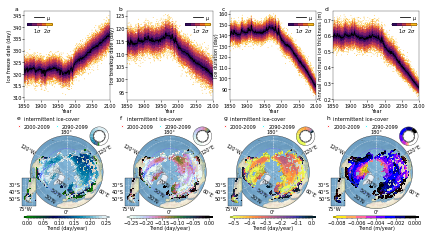

In [141]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize = (18 * cm,10 * cm))
plt.subplots_adjust(hspace = 0.4)
#
ax = fig.add_subplot(2,4,1)
line_span_plot(input_data=iceon_mod_x, 
               axs = ax, 
               cmap = mpl.colors.ListedColormap(plt.cm.get_cmap('inferno',7)(range(1,6))),  
               cax_adjust=[0.04,0.83,0.0,0],
               cb_fraction = 0.1,
               cb_shrink = 0.1,
               vline_txt_yloc=313, 
               ylims = (309,347),
               yticks = np.arange(310,346,5),
               ylabel = 'Ice freeze date (day)',
              legend_loc=(0.1,0.85)
              )
ax.text(-0.1,1, 'a', fontsize = 6, transform = ax.transAxes)
ax.set_xlim(1850,2100)
#
ax = fig.add_subplot(2,4,2)
line_span_plot(input_data=iceoff_mod_x, 
               axs = ax, 
               cmap = mpl.colors.ListedColormap(plt.cm.get_cmap('inferno',7)(range(1,6))),  
               cax_adjust=[0.68,0.83,0,0],
               cb_fraction = 0.1,
               cb_shrink = 0.1,
               vline_txt_yloc=313, 
               ylims = (92,127),
               yticks = np.arange(95,127,5),
               y_offset=365, 
               ylabel='Ice breakup date (day)',
              legend_loc=(0.75,0.85)
              )
ax.text(-0.1,1, 'b', fontsize = 6, transform = ax.transAxes)
ax.set_xlim(1850,2100)
#
ax = fig.add_subplot(2,4,3)
line_span_plot(input_data=iceduration_mod_x, 
               axs = ax, 
               cmap = mpl.colors.ListedColormap(plt.cm.get_cmap('inferno',7)(range(1,6))),  
               cax_adjust=[0.68,0.83,0,0],
               cb_fraction = 0.1,
               cb_shrink = 0.1,
               vline_txt_yloc=313, 
               ylims = (80,163),
               yticks = np.arange(90,161,10),
               ylabel='Ice duration (day)',
              legend_loc=(0.75,0.85)
              )
ax.text(-0.1,1, 'c', fontsize = 6, transform = ax.transAxes)
ax.set_xlim(1850,2100)
#
ax = fig.add_subplot(2,4,4)
line_span_plot(input_data=daily_ice_max_x, 
               axs = ax, 
               cmap = mpl.colors.ListedColormap(plt.cm.get_cmap('inferno',7)(range(1,6))),  
               cax_adjust=[0.68,0.83,0,0],
               cb_fraction = 0.1,
               cb_shrink = 0.1,
               vline_txt_yloc=313, 
               ylims = (0.195,0.76),
               yticks = np.arange(0.2,0.71,0.1),
               ylabel='Annual maximum ice thickness (m)',
              legend_loc=(0.75,0.85)
              )
ax.text(-0.1,1, 'd', fontsize = 6, transform = ax.transAxes)
ax.set_xlim(1850,2100)
#
##
ax = fig.add_subplot(2,4,5, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('ocean', 26)
cmap = mpl.colors.ListedColormap(cmap(np.arange(25))) ## this step is only special for this kind colormap \
                                                      ## for where they have white color at the end, 
                                                      ##which will mix with tropical ice free lakes in the pie chart
picolors = cmap(np.linspace(0,1,25))
pcolor_pie_plot(input_data=iceon_trend2000_2100_ensmean, mother_axs=ax, 
                cmap= cmap,
                picolors=picolors,
                cmap_ninterv= 25,
                vmin = 0,
                vmax = 0.25,
                SH_adjust= [-0.05,0.2,0.02,0.03],
                pie_adjust=[0.23,0.36,0.1,0.1],
                cb_shrink=1,
                cb_aspect=30,
                cb_pad = 0.08,
                hatch_label=True)
ax.text(-0.18,1.22, 'e', fontsize = 6, transform = ax.transAxes)
##
ax = fig.add_subplot(2,4,6, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('cubehelix_r', 26)
cmap = mpl.colors.ListedColormap(cmap(np.arange(1,26))) ## this step is only special for this kind colormap \
                                                      ## for where they have white color at the end, 
                                                      ##which will mix with tropical ice free lakes in the pie chart
                                                ## and notice here is 1-26, the upper is 0-25, because the upper colormap with white in the end
                                                ## but this colormap with white in the begining
picolors = cmap(np.linspace(0,1,25))
pcolor_pie_plot(input_data=iceoff_trend2000_2100_ensmean, mother_axs=ax, 
                SH_adjust= [-0.05,0.2,0.02,0.03],
                pie_adjust=[0.23,0.36,0.1,0.1],
                cmap= cmap,
                picolors=picolors,
                cmap_ninterv = 25,
                vmin = -0.25,
                vmax = 0,
                cb_shrink=1,
                cb_aspect=30,
                cb_pad = 0.08,
                hatch_label=True)
ax.text(-0.18,1.22, 'f', fontsize = 6, transform = ax.transAxes)
##
ax = fig.add_subplot(2,4,7, projection = ccrs.Orthographic(central_latitude=90))
picolors = cmocean.cm.thermal_r(np.linspace(0,1,25))
cmap = mpl.colors.ListedColormap(picolors)
pcolor_pie_plot(input_data=iceduration_trend2000_2100_ensmean, mother_axs=ax, 
                cmap= cmap,
                picolors=picolors,
                SH_adjust= [-0.05,0.2,0.02,0.03],
                pie_adjust=[0.23,0.36,0.1,0.1],
                cb_shrink=1,
                cb_aspect=30,
                cb_pad = 0.08,
                hatch_label=True)
ax.text(-0.18,1.22, 'g', fontsize = 6, transform = ax.transAxes)
##
ax = fig.add_subplot(2,4,8, projection = ccrs.Orthographic(central_latitude=90))
cmap = plt.cm.get_cmap('gnuplot2_r', 9)
cmap = mpl.colors.ListedColormap(cmap(np.arange(1,9))) ## this step is only special for this kind colormap \
                                                      ## for where they have white color at the end, 
                                                      ##which will mix with tropical ice free lakes in the pie chart
                                                ## and notice here is 1-26, the upper is 0-25, because the upper colormap with white in the end
                                                ## but this colormap with white in the begining
picolors = cmap(np.linspace(0,1,8))
pcolor_pie_plot(input_data=daily_ice_max_trend, mother_axs=ax, 
                SH_adjust= [-0.05,0.2,0.02,0.03],
                pie_adjust=[0.23,0.36,0.1,0.1],
                cmap= cmap,
                picolors=picolors,
                cmap_ninterv = 8,
                vmin = -0.008,
                vmax = 0,
                cb_shrink=1,
                cb_aspect=30,
                cb_pad = 0.08,
                cb_label='Trend (m/year)',
                hatch_label=True)
ax.text(-0.18,1.22, 'h', fontsize = 6, transform = ax.transAxes)
##
plt.savefig('/proj/lhuang/scripts/CESM2-LENS/LAKE_ICE/Fig_1.pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)
plt.close(fig)